In [2]:
import pandas as pd
import jinja2
from sklearn import tree
from sklearn.preprocessing import scale as scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend, callbacks

import keras_tuner as kt
from tensorflow import keras
from kerastuner.tuners import RandomSearch
# import tensorflow.keras import layers

C:\Users\Phili\AppData\Local\Temp/ipykernel_60464/1293208691.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Data preperation and knowledge

In [3]:
# read the csv file
match_data_unfiltered = pd.read_csv("preprocessed_dataframe_with_elo_mw_form_3.csv")
# match_data_unfiltered.to_excel("exel_test.xlsx")

In [4]:
# make FTR column to continous variable
def convert_ftr(result: str):
    if result == "D":
        return 1
    elif result == "H":
        return 2
    elif result == "A":
        return 0
    else: 
        return None
match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)

In [5]:
match_data_unfiltered = match_data_unfiltered.drop(["Unnamed: 0"], axis=1, errors="ignore")
# print(match_data_unfiltered.columns)
match_data_unfiltered.iloc[4589:4594].tail(n=5)

,Unnamed: 0.2,index,Unnamed: 0.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,QuotAttack,QuotDefend,DirectComparisonHG,DirectComparisonAG,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot
4589,4589,4589,4589,D1,22/05/2021,Wolfsburg,Mainz,2,3,0,...,1.154804,1.267976,2.0,0.0,H,False,H,False,2.0,inf
4590,4590,4590,4590,D1,13/08/2021,M'gladbach,Bayern Munich,1,1,1,...,0.677409,1.498934,1.4,3.2,A,False,A,False,-1.8,0.437500
4591,4591,4591,4591,D1,14/08/2021,Augsburg,Hoffenheim,0,4,0,...,0.286204,4.737221,1.6,2.6,A,True,A,True,-1.0,0.615385
4592,4592,4592,4592,D1,14/08/2021,Bielefeld,Freiburg,0,0,1,...,0.335041,0.064789,0.8,1.5,A,False,A,False,-0.7,0.533333
4593,4593,4593,4593,D1,14/08/2021,Stuttgart,Greuther Furth,5,1,2,...,2.563037,0.407930,1.1,1.2,H,True,H,True,-0.1,0.916667


In [6]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()[['FTR', 'FTHG', 'FTAG']]
correlation_matrix_match_data_unfiltered = correlation_matrix_match_data_unfiltered.dropna()
correlation_matrix_match_data_unfiltered = correlation_matrix_match_data_unfiltered.iloc[6:].T
correlation_matrix_match_data_unfiltered.style.background_gradient()

,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,GPHTH,GPHTA,GPATH,GPATA,GPHT,GPAT,PointsLast3MatchesHT,PointsLast3MatchesAT,PointsLast5MatchesHT,PointsLast5MatchesAT,PointsLast10MatchesHT,PointsLast10MatchesAT,PointsLastAllMatchesHT,PointsLastAllMatchesAT,PDiff3Matches,PQuot3Matches,PDiff5Matches,PQuot5Matches,PDiff10Matches,PQuot10Matches,PDiffAllMatches,PQuotAllMatches,MarketValueHT,MarketValueAT,MarketValueDiff,MarketValueQuot,BSH,BSD,BSA,PSH,PSD,PSA,PSCH,PSCD,PSCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,HomeElo,AwayElo,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld,DiffEloOld,DiffAttackOld,DiffDefendOld,DiffElo,DiffAttack,DiffDefend,QuotEloOld,QuotAttackOld,QuotDefendOld,QuotElo,QuotAttack,QuotDefend,DirectComparisonHG,DirectComparisonAG,BetTrue,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot
FTR,0.425434,-0.439499,0.189774,-0.201513,0.354642,-0.369956,-0.043109,0.004917,-0.007333,-0.040962,-0.114128,0.059165,-0.138916,0.090794,-0.294872,0.135288,0.287191,-0.297483,0.132422,0.292715,-0.273634,0.172241,0.293147,-0.299923,0.132400,0.290212,-0.283740,0.138704,0.268156,-0.250571,0.199753,0.286740,-0.288846,0.126903,0.280156,-0.282508,0.174128,0.287340,-0.291356,0.130886,0.274565,0.022474,-0.282144,-0.289801,0.145512,0.141913,0.258877,0.276592,-0.007097,-0.087338,-0.086714,0.106874,0.103641,0.008800,-0.344311,-0.040921,-0.036600,0.035046,0.036752,0.004288,0.002180,0.002649,0.003850,0.003240,0.003257,0.146068,-0.104061,0.174008,-0.139328,0.213812,-0.168185,0.110531,-0.095961,0.178228,0.124263,0.223991,0.149030,0.276164,0.191869,0.270011,0.170821,0.185308,-0.221767,0.306257,0.232851,-0.280200,0.179951,0.296946,-0.319931,0.134852,0.292176,-0.323349,0.123394,0.290366,-0.301097,0.136856,0.294485,-0.311532,0.138478,0.316354,-0.032510,0.080016,-0.025189,0.064711,-0.036725,0.083020,-0.037108,0.080698,-0.396961,-0.030629,0.045975,-0.048912,0.041376,-0.020007,0.021182,-0.031487,0.027347,-0.318045,0.119873,0.319080,-0.318411,0.119516,0.322839,-0.329464,0.134902,0.325046,-0.309569,0.111017,0.309210,-0.314411,0.123742,0.305080,-0.301595,0.118078,0.297488,-0.316413,0.120142,0.314032,-0.028877,0.072935,-0.015512,0.047199,-0.030424,0.077638,-0.024189,0.072182,-0.394376,-0.087733,0.066853,-0.076585,0.075285,-0.046776,0.084993,-0.064095,0.064207,0.136268,-0.151051,0.538492,0.535578,-0.495349,-0.505048,0.175902,0.108135,-0.151120,-0.092621,0.100912,-0.115695,0.265837,0.231165,0.142717,0.357794,0.701484,0.702171,0.249900,-0.018272,0.003521,0.342552,0.032605,-0.034128,0.189993,-0.185371,0.349281,0.539503,0.240582,0.174501
FTHG,0.691083,-0.066105,0.282759,-0.121474,0.529431,-0.122165,-0.110952,-0.079891,0.024723,-0.068897,-0.128651,0.020357,-0.084379,0.065876,-0.236163,0.227526,0.317219,-0.239109,0.224738,0.326860,-0.224992,0.209713,0.277136,-0.244343,0.228147,0.322899,-0.238475,0.211580,0.299688,-0.213540,0.215740,0.276230,-0.232653,0.226225,0.320615,-0.234065,0.217915,0.280378,-0.233330,0.226317,0.314291,-0.007988,-0.231360,-0.239320,0.214325,0.212778,0.281777,0.299525,-0.066992,-0.200748,-0.201109,0.217265,0.216824,-0.013594,-0.325640,-0.045549,-0.038526,0.034930,0.035937,0.015040,0.011525,0.011211,0.015040,0.013318,0.013160,0.154669,-0.077203,0.185497,-0.100455,0.225746,-0.114229,0.128810,-0.060684,0.164853,0.114681,0.204178,0.126088,0.245761,0.173905,0.247885,0.1729

In [10]:
# filter for specific columns
# match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeElo", "AwayElo", "HomeAttack", "HomeDefend", "AwayAttack", "AwayDefend"]]
# "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    # "AwayAttackOld", "AwayDefendOld"
# print correlation matrix
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "DiffEloOld", "HomeAttackOld", "HomeDefendOld", "AwayAttackOld", "AwayDefendOld", "DiffDefendOld", "DiffAttackOld", "MarketValueDiff", "PDiff3Matches", 'PDiffAllMatches', 'PQuotAllMatches', 'DirectComparisonGoalDiff', 'DirectComparisonGoalQuot', 'DirectComparisonHG', 'DirectComparisonAG']]

correlation_matrix_match_data_reduced = match_data_reduced.corr()[['FTR', 'FTHG', 'FTAG']].iloc[3:].T
correlation_matrix_match_data_reduced.style.background_gradient()

,HomeEloOld,AwayEloOld,DiffEloOld,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,DiffDefendOld,DiffAttackOld,MarketValueDiff,PDiff3Matches,PDiffAllMatches,PQuotAllMatches,DirectComparisonGoalDiff,DirectComparisonGoalQuot,DirectComparisonHG,DirectComparisonAG
FTR,0.100912,-0.115695,0.265837,0.175902,0.108135,-0.151120,-0.092621,0.142717,0.231165,0.306257,0.178228,0.270011,0.170821,0.240582,0.174501,0.189993,-0.185371
FTHG,0.165829,-0.045695,0.259707,0.210148,0.099480,-0.090360,-0.084673,0.130912,0.209837,0.308663,0.164853,0.247885,0.172969,0.252000,0.220120,0.239505,-0.155700
FTAG,-0.028317,0.149910,-0.218648,-0.090111,-0.068295,0.168209,0.084305,-0.108572,-0.185204,-0.254907,-0.145809,-0.228080,-0.136680,-0.190884,-0.127267,-0.112668,0.183249


In [11]:
# focus on best Features
correlation_matrix_match_data_reduced = correlation_matrix_match_data_reduced.loc[:, ["DiffEloOld", "DiffDefendOld", "DiffAttackOld", "MarketValueDiff", "PDiff3Matches", "DirectComparisonGoalDiff", "PDiffAllMatches"]]
correlation_matrix_match_data_reduced.style.background_gradient()

,DiffEloOld,DiffDefendOld,DiffAttackOld,MarketValueDiff,PDiff3Matches,DirectComparisonGoalDiff,PDiffAllMatches
FTR,0.265837,0.142717,0.231165,0.306257,0.178228,0.240582,0.270011
FTHG,0.259707,0.130912,0.209837,0.308663,0.164853,0.252000,0.247885
FTAG,-0.218648,-0.108572,-0.185204,-0.254907,-0.145809,-0.190884,-0.228080


In [13]:
match_data_bl = match_data_unfiltered.copy(deep=True)
# match_data_bl = match_data_bl.dropna(subset=["PDiff3Matches"])
# match_data_unfiltered = match_data_unfiltered.dropna(subset=["PDiff10Matches"])

In [ ]:
# # X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
# #     "AwayAttackOld", "AwayDefendOld"
# # ]]
# features = ["DiffEloOld", "DiffAttackOld", "DiffDefendOld", "PDiff3Matches", "PDiff10Matches", "PQuotAllMatches", 
#             "MarketValueDiff", "DirectComparisonHG", "DirectComparisonAG"]
# #  "PDiff10Matches",
# match_data_bl_wo_nan = match_data_bl.dropna(subset=features)
# X = match_data_bl_wo_nan.loc[:, features]
# X_scaled = scale(X)
# # y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
# y = match_data_bl_wo_nan.loc[:, ["FTR"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled,
#                                                     y,
#                                                     test_size=0.33,
#                                                     random_state=42)


In [24]:
# X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
#     "AwayAttackOld", "AwayDefendOld"
# ]]
features = ["DiffEloOld", "DiffAttackOld", "DiffDefendOld", "PDiff3Matches", "PDiff10Matches", "PQuotAllMatches", 
            "MarketValueDiff", "DirectComparisonHG", "DirectComparisonAG"]
#  "PDiff10Matches",
match_data_bl_wo_nan = match_data_bl.dropna(subset=features)
# X = match_data_bl_wo_nan.loc[:, features]
# X_scaled = scale(X)
# y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
y = match_data_bl_wo_nan.loc[:, ["FTR"]]
X_train_df, X_test_df, y_train, y_test = train_test_split(match_data_bl_wo_nan, y, test_size=0.33, random_state=42)
X_train = X_train_df.loc[:, features]
X_test = X_test_df.loc[:, features]
X = match_data_bl_wo_nan.loc[:, features]

# X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled,
#                                                     y,
#                                                     test_size=0.33,
#                                                     random_state=42)


## Train Decision Tree Classifier as first Model

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
clf_scaled = tree.DecisionTreeClassifier()
clf_scaled = clf_scaled.fit(X_train_scaled, y_train)

In [ ]:
clf.predict(X_test)

array([2, 2, 1, ..., 1, 1, 0], dtype=int64)

In [ ]:
clf_scaled.predict(X_test_scaled)

array([0, 2, 1, ..., 1, 1, 0], dtype=int64)

In [ ]:
result = clf.score(X_test, y_test)
result_scaled = clf_scaled.score(X_test_scaled, y_test)

In [ ]:
result

0.4005258545135846

In [ ]:
result_scaled

0.39964943032427697

Confusion matrix, without normalization
[[120 101 136]
 [ 67  67 134]
 [117 129 270]]
Normalized confusion matrix
[[0.33613445 0.28291317 0.38095238]
 [0.25       0.25       0.5       ]
 [0.22674419 0.25       0.52325581]]


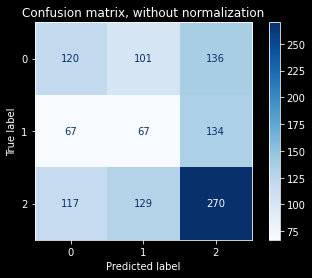

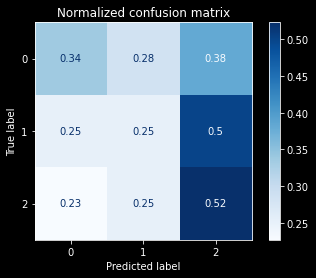

In [ ]:
class_names = {
    'Away'
    ,'Draw',
    'Home'
}
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Ensemble Learning

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from sklearn import linear_model

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
# X = match_data_unfiltered.loc[:, [
#     "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
#     "AwayAttackOld", "AwayDefendOld"
# ]]

# y = match_data_unfiltered.loc[:, ["FTR"]]

In [ ]:
match_data_unfiltered

,Unnamed: 0.2,index,Unnamed: 0.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,QuotAttack,QuotDefend,DirectComparisonHG,DirectComparisonAG,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot
0,0,0,0,D1,11/08/06,Bayern Munich,Dortmund,2,0,2,...,2.215589,0.411358,NaN,NaN,H,True,H,True,NaN,NaN
1,1,1,1,D1,12/08/06,Hamburg,Bielefeld,1,1,1,...,0.982162,0.982162,NaN,NaN,H,False,H,False,NaN,NaN
2,2,2,2,D1,12/08/06,Leverkusen,Aachen,3,0,2,...,2.878939,0.324259,NaN,NaN,H,True,H,True,NaN,NaN
3,3,3,3,D1,12/08/06,Mainz,Bochum,2,1,2,...,1.401889,0.718342,NaN,NaN,H,True,H,True,NaN,NaN
4,4,4,4,D1,12/08/06,M'gladbach,Cottbus,2,0,2,...,2.215589,0.411358,NaN,NaN,H,True,H,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,4891,4891,4891,D1,14/05/2022,Mainz,Ein Frankfurt,2,2,1,...,1.707233,1.191627,1.0,1.0,H,False,H,False,0.0,1.000000
4892,4892,4892,4892,D1,14/05/2022,M'gladbach,Hoffenheim,5,1,2,...,2.032081,0.266797,1.6,1.4,H,True,H,True,0.2,1.142857
4893,4893,4893,4893,D1,14/05/2022,Stuttgart,FC Koln,2,1,2,...,0.970749,0.803116,1.4,1.0,H,True,H,True,0.4,1.400000
4894,4894,4894,4894,D1,14/05/2022,Union Berlin,Bochum,3,2,2,...,1.476492,0.532022,1.8,1.1,H,True,H,True,0.7,1.636364


In [ ]:
# X = match_data_bl.loc[:, ["DiffEloOld", "DiffAttackOld", "DiffDefendOld", "PDiff3Matches", "PDiffAllMatches", "MarketValueDiff"
# ]]
# X = X.dropna()
# #"PDiff10Matches",
# # y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
# y = match_data_bl.loc[:, ["FTR"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['lda'] = LinearDiscriminantAnalysis()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models

In [ ]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = cross_val_score(model,
                             X,
                             y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    return scores

>lr 0.510 (0.013)
>lda 0.505 (0.012)
>knn 0.423 (0.016)
>cart 0.398 (0.018)
>svm 0.504 (0.012)
>bayes 0.473 (0.015)


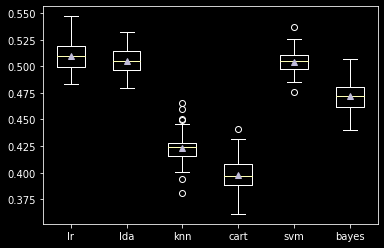

In [ ]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>lr 0.508 (0.014)
>lda 0.505 (0.012)
>knn 0.429 (0.014)
>cart 0.396 (0.018)
>svm 0.509 (0.013)
>bayes 0.473 (0.015)


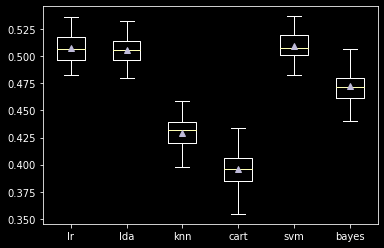

In [ ]:
# scaled X

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_scaled, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
X

,DiffEloOld,DiffAttackOld,DiffDefendOld,PDiff3Matches,PDiff10Matches,PQuotAllMatches,MarketValueDiff,DirectComparisonHG,DirectComparisonAG
90,10.206248,-0.790160,2.735138,3.0,2.0,1.166667,53.05,1.3,1.7
91,-18.300659,-0.044881,-2.152344,-6.0,-5.0,0.615385,-19.87,0.9,0.7
92,-34.677451,-2.431904,-0.756095,-5.0,-7.0,0.650000,-91.80,1.2,2.8
93,44.494676,2.776786,-0.139413,3.0,9.0,2.000000,-4.75,2.1,1.0
94,89.795027,1.876188,0.211856,3.0,10.0,2.428571,134.88,1.6,0.9
...,...,...,...,...,...,...,...,...,...
4891,5.106425,1.215809,-0.215011,4.0,1.0,1.097561,-130.75,1.0,1.0
4892,22.074235,-0.013209,2.041610,4.0,7.0,0.913043,92.35,1.6,1.4
4893,-27.347735,-0.913907,-0.445764,-4.0,-6.0,0.576923,92.97,1.4,1.0
4894,356.589890,0.812772,1.160533,1.0,7.0,1.285714,40.90,1.8,1.1


### Stack the single models to a combination

In [ ]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('lda', LinearDiscriminantAnalysis()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model


In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['lda'] = LinearDiscriminantAnalysis()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models


>lr 0.510 (0.013)
>lda 0.505 (0.012)
>knn 0.423 (0.016)
>cart 0.399 (0.016)
>svm 0.504 (0.012)
>bayes 0.473 (0.015)
>stacking 0.508 (0.013)


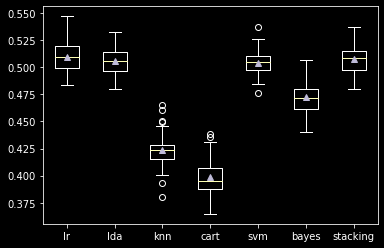

In [ ]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Neural Network

In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical


In [ ]:
# X = match_data_unfiltered.loc[:, [
#     "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
#     "AwayAttackOld", "AwayDefendOld"
# ]]

# y = match_data_unfiltered.loc[:, ["FTR"]]
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.33,
#                                                     random_state=42)
# X_train = X
# y_train = y

print(X_train.shape)
print(X_test.shape)


(2315, 9)
(1141, 9)


In [ ]:
y_train

,FTR
4689,2
3551,0
1968,1
1772,2
2632,0
...,...
1635,2
1670,2
1834,2
1220,1


In [16]:
def one_hot_encode_outputs(y_train, y_test):
    # one hot encode outputs
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    count_classes = y_test.shape[1]
    print(count_classes)
    return y_train, y_test

In [17]:
def train_model(X_train, y_train, number_of_epochs=20):
    model = Sequential()
    # model.add(Dense(500, activation='relu', input_dim=6))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(50, activation='relu'))
    # model.add(Dense(3, activation='softmax'))

    model.add(Dense(500, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # build the model
    history = model.fit(X_train, y_train, epochs=number_of_epochs)
    return history, model

In [18]:
def print_accuracy(X_train, y_train, X_test, y_test, model):
    pred_train= model.predict(X_train)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
    
    pred_test= model.predict(X_test)
    scores2 = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))  
    return pred_train, pred_test

In [19]:
def get_predictions(pred_test, y_test):
    # y_pred = [[1 if np.max(j)==i for i in j else 0] for j in pred_test]
    y_pred = []
    alpha = 0.05
    beta = 0.1
    for test in pred_test:
        # list_temp = []
        # for counter, j in enumerate(test):
        #     if np.max(test)==j:
        #         y_pred.append(counter)
        # print(test[1])
        if test[2] > test[1] and test[2] > test[0] and abs(test[2] - test[0]) > alpha:
            # if test[2] > test[1]+alpha and test[2] > test[0]:

            y_pred.append(2)
        elif test[0] > test[1] and abs(test[2] - test[0]) > alpha:
            y_pred.append(0)
        else:
            y_pred.append(1)
            #     list_temp.append(1)
            # else:
            #     list_temp.append(0)
        # y_pred.append(list_temp)
    y_pred
    y_test_res = []
    for test in y_test:
        # list_temp = []
        for counter, j in enumerate(test):
            if np.max(test)==j:
                y_test_res.append(counter)
    return y_test_res, y_pred

In [20]:
def print_confusion_matrix(y_test_res, y_pred):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cf = confusion_matrix(y_test_res, y_pred) #, labels=["Draw", "Home", "Away"])
    cfd = ConfusionMatrixDisplay(cf, display_labels=["Away", "Draw", "Home"])
    cfd.plot(cmap=plt.cm.Blues)

### test first NN with random data

3
Epoch 1/15
73/73 [==============================] - 1s 2ms/step - loss: 2.2256 - accuracy: 0.3978
Epoch 2/15
73/73 [==============================] - 0s 2ms/step - loss: 1.3223 - accuracy: 0.4229
Epoch 3/15
73/73 [==============================] - 0s 3ms/step - loss: 1.1904 - accuracy: 0.4488
Epoch 4/15
73/73 [==============================] - 0s 2ms/step - loss: 1.2086 - accuracy: 0.4415
Epoch 5/15
73/73 [==============================] - 0s 2ms/step - loss: 1.2260 - accuracy: 0.4657
Epoch 6/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0767 - accuracy: 0.4786
Epoch 7/15
73/73 [==============================] - 0s 2ms/step - loss: 1.1113 - accuracy: 0.4691
Epoch 8/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0796 - accuracy: 0.4665
Epoch 9/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0581 - accuracy: 0.4756
Epoch 10/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0361 - accuracy: 0.4795
Epoch 11/15
73/73

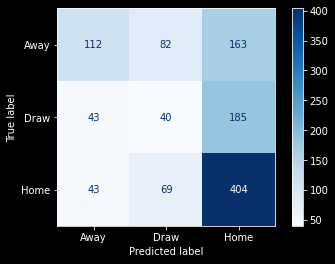

In [21]:
# learn model with random split for train test data
y_train, y_test = one_hot_encode_outputs(y_train, y_test)
trained_model_history, model = train_model(X_train, y_train, number_of_epochs=15)
pred_train, pred_test = print_accuracy(X_train, y_train, X_test, y_test, model)
y_test_res, y_pred = get_predictions(pred_test, y_test)
print_confusion_matrix(y_test_res, y_pred)

Epoch 1/15
73/73 [==============================] - 1s 6ms/step - loss: 1.0226 - accuracy: 0.4890
Epoch 2/15
73/73 [==============================] - 0s 5ms/step - loss: 1.0117 - accuracy: 0.5024
Epoch 3/15
73/73 [==============================] - 0s 5ms/step - loss: 1.0016 - accuracy: 0.5093
Epoch 4/15
73/73 [==============================] - 1s 7ms/step - loss: 0.9977 - accuracy: 0.5145: 0s - loss: 1.0130 
Epoch 5/15
73/73 [==============================] - 1s 10ms/step - loss: 0.9945 - accuracy: 0.5140 0s - loss: 0.9956 - accuracy: 0.51
Epoch 6/15
73/73 [==============================] - 1s 7ms/step - loss: 0.9876 - accuracy: 0.5171
Epoch 7/15
73/73 [==============================] - 0s 5ms/step - loss: 0.9788 - accuracy: 0.5266
Epoch 8/15
73/73 [==============================] - 0s 5ms/step - loss: 0.9725 - accuracy: 0.5283
Epoch 9/15
73/73 [==============================] - 0s 5ms/step - loss: 0.9663 - accuracy: 0.5395
Epoch 10/15
73/73 [==============================] - 0s 5ms/st

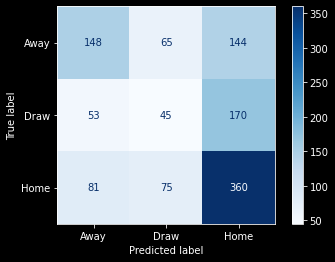

In [ ]:
# X scaled

# learn model with random split for train test data
# y_train, y_test = one_hot_encode_outputs(y_train, y_test)
trained_model_history, model = train_model(X_train_scaled,
                                           y_train,
                                           number_of_epochs=15)
pred_train, pred_test = print_accuracy(X_train_scaled, y_train, X_test_scaled, y_test, model)
y_test_res, y_pred = get_predictions(pred_test, y_test)
print_confusion_matrix(y_test_res, y_pred)

In [ ]:
X_scaled

array([[ 0.06230872, -0.53728222,  2.49085037, ...,  0.28628604,
        -0.14958268,  0.35082572],
       [-0.06853286,  0.04519897, -1.80222433, ..., -0.09777059,
        -0.76663075, -1.1333571 ],
       [-0.14369939, -1.82040555, -0.57578509, ..., -0.47661307,
        -0.3038447 ,  1.98342681],
       ...,
       [-0.11005731, -0.63399797, -0.30319594, ...,  0.49653756,
         0.00467934, -0.68810225],
       [ 1.65214734,  0.71550757,  1.10774606, ...,  0.22229416,
         0.62172741, -0.53968397],
       [-1.32953057, -0.16110993,  0.91527541, ..., -2.96966308,
        -1.2294168 ,  2.28026337]])

### test first NN with last season data

In [ ]:
# split train test data to predict one season
# take the last 306 - 10*9 datapoints (because first 10 Matches are needed for the form)

X_train_s_2022, X_test_s_2022 = X.iloc[:-216], X.iloc[-216:]
y_train_s_2022, y_test_s_2022 = y[:-216], y[-216:]
match_data_bl_wo_nan_s_2022 = match_data_bl_wo_nan.iloc[-216:]

3
Epoch 1/15
102/102 [==============================] - 1s 3ms/step - loss: 1.6338 - accuracy: 0.4401
Epoch 2/15
102/102 [==============================] - 0s 3ms/step - loss: 1.2197 - accuracy: 0.4559
Epoch 3/15
102/102 [==============================] - 0s 2ms/step - loss: 1.1718 - accuracy: 0.4694
Epoch 4/15
102/102 [==============================] - 0s 2ms/step - loss: 1.1223 - accuracy: 0.4596
Epoch 5/15
102/102 [==============================] - 0s 2ms/step - loss: 1.0887 - accuracy: 0.4756
Epoch 6/15
102/102 [==============================] - 0s 2ms/step - loss: 1.0474 - accuracy: 0.4824
Epoch 7/15
102/102 [==============================] - 0s 2ms/step - loss: 1.0421 - accuracy: 0.4861
Epoch 8/15
102/102 [==============================] - 0s 3ms/step - loss: 1.0234 - accuracy: 0.4935
Epoch 9/15
102/102 [==============================] - 0s 4ms/step - loss: 1.0259 - accuracy: 0.4978
Epoch 10/15
102/102 [==============================] - 0s 4ms/step - loss: 1.0183 - accuracy: 0.51

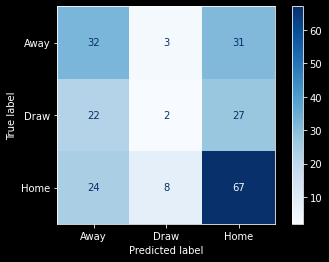

In [ ]:
# train model and get results for one season predictions 
y_train_s_2022, y_test_s_2022 = one_hot_encode_outputs(y_train_s_2022, y_test_s_2022)
trained_model_history_s_2022, model_s_2022 = train_model(X_train_s_2022, y_train_s_2022, number_of_epochs=15)
pred_train_s_2022, pred_test_s_2022 = print_accuracy(X_train_s_2022, y_train_s_2022, X_test_s_2022, y_test_s_2022, model_s_2022)
y_test_res_s_2022, y_pred_s_2022 = get_predictions(pred_test_s_2022, y_test_s_2022)
print_confusion_matrix(y_test_res_s_2022, y_pred_s_2022)

In [25]:
# X scaled

# split train test data to predict one season
# take the last 306 - 10*9 datapoints (because first 10 Matches are needed for the form)

X_train_s_2022_scaled, X_test_s_2022_scaled = X_scaled[:-216], X_scaled[-216:]
y_train_s_2022, y_test_s_2022 = y[:-216], y[-216:]
match_data_bl_wo_nan_s_2022 = match_data_bl_wo_nan.iloc[-216:]

NameError: name 'X_scaled' is not defined

In [ ]:
# combine match data for season 22 with predictions for season 2022 for betting strategy

match_data_bl_wo_nan_s_2022.loc[:,'predictedResults'] = y_pred_s_2022
match_data_bl_wo_nan_s_2022

C:\Users\Phili\AppData\Local\Temp/ipykernel_32456/1960349365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data_bl_wo_nan_s_2022.loc[:,'predictedResults'] = y_pred_s_2022


,Unnamed: 0.2,index,Unnamed: 0.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,QuotDefend,DirectComparisonHG,DirectComparisonAG,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot,predictedResults
4680,4680,4680,4680,D1,05/11/2021,Mainz,M'gladbach,1,1,1,...,1.438142,1.2,2.20,A,False,A,False,-1.00,0.545455,0
4681,4681,4681,4681,D1,06/11/2021,Bayern Munich,Freiburg,2,1,2,...,0.937499,2.2,1.20,H,True,H,True,1.00,1.833333,2
4682,4682,4682,4682,D1,06/11/2021,Bochum,Hoffenheim,2,0,2,...,0.395446,1.5,1.75,A,False,A,False,-0.25,0.857143,0
4683,4683,4683,4683,D1,06/11/2021,Stuttgart,Bielefeld,0,1,0,...,1.455523,0.8,1.80,H,False,H,False,-1.00,0.444444,2
4684,4684,4684,4684,D1,06/11/2021,Wolfsburg,Augsburg,1,0,2,...,0.297315,2.4,0.40,H,True,H,True,2.00,6.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,4891,4891,4891,D1,14/05/2022,Mainz,Ein Frankfurt,2,2,1,...,1.191627,1.0,1.00,H,False,H,False,0.00,1.000000,2
4892,4892,4892,4892,D1,14/05/2022,M'gladbach,Hoffenheim,5,1,2,...,0.266797,1.6,1.40,H,True,H,True,0.20,1.142857,2
4893,4893,4893,4893,D1,14/05/2022,Stuttgart,FC Koln,2,1,2,...,0.803116,1.4,1.00,H,True,H,True,0.40,1.400000,2
4894,4894,4894,4894,D1,14/05/2022,Union Berlin,Bochum,3,2,2,...,0.532022,1.8,1.10,H,True,H,True,0.70,1.636364,2


In [ ]:
df_season_2022_percentage_res = pd.DataFrame(pred_test_s_2022, columns=['ProbAwayWin', 'ProbDraw', 'ProbHomeWin'], index=match_data_bl_wo_nan_s_2022.index)
match_data_bl_wo_nan_s_2022.loc[:, ['ProbAwayWin', 'ProbDraw', 'ProbHomeWin']] = df_season_2022_percentage_res
match_data_bl_wo_nan_s_2022

C:\Users\Phili\AppData\Local\Temp/ipykernel_32456/2965493251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data_bl_wo_nan_s_2022.loc[:, ['ProbAwayWin', 'ProbDraw', 'ProbHomeWin']] = df_season_2022_percentage_res


,Unnamed: 0.2,index,Unnamed: 0.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot,predictedResults,ProbAwayWin,ProbDraw,ProbHomeWin
4680,4680,4680,4680,D1,05/11/2021,Mainz,M'gladbach,1,1,1,...,A,False,A,False,-1.00,0.545455,0,0.503266,0.216746,0.279988
4681,4681,4681,4681,D1,06/11/2021,Bayern Munich,Freiburg,2,1,2,...,H,True,H,True,1.00,1.833333,2,0.029052,0.123058,0.847890
4682,4682,4682,4682,D1,06/11/2021,Bochum,Hoffenheim,2,0,2,...,A,False,A,False,-0.25,0.857143,0,0.585537,0.167955,0.246508
4683,4683,4683,4683,D1,06/11/2021,Stuttgart,Bielefeld,0,1,0,...,H,False,H,False,-1.00,0.444444,2,0.225263,0.237947,0.536789
4684,4684,4684,4684,D1,06/11/2021,Wolfsburg,Augsburg,1,0,2,...,H,True,H,True,2.00,6.000000,2,0.160011,0.248897,0.591092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,4891,4891,4891,D1,14/05/2022,Mainz,Ein Frankfurt,2,2,1,...,H,False,H,False,0.00,1.000000,2,0.313396,0.261667,0.424938
4892,4892,4892,4892,D1,14/05/2022,M'gladbach,Hoffenheim,5,1,2,...,H,True,H,True,0.20,1.142857,2,0.171229,0.297454,0.531317
4893,4893,4893,4893,D1,14/05/2022,Stuttgart,FC Koln,2,1,2,...,H,True,H,True,0.40,1.400000,2,0.179828,0.289596,0.530576
4894,4894,4894,4894,D1,14/05/2022,Union Berlin,Bochum,3,2,2,...,H,True,H,True,0.70,1.636364,2,0.242568,0.252462,0.504969


In [ ]:
match_data_bl_wo_nan_s_2022.to_csv("./match_data_bl_wo_nan_s_2022.csv")

In [ ]:
df_season_2022_percentage_res

,ProbAwayWin,ProbDraw,ProbHomeWin
4680,0.503266,0.216746,0.279988
4681,0.029052,0.123058,0.847890
4682,0.585537,0.167955,0.246508
4683,0.225263,0.237947,0.536789
4684,0.160011,0.248897,0.591092
...,...,...,...
4891,0.313396,0.261667,0.424938
4892,0.171229,0.297454,0.531317
4893,0.179828,0.289596,0.530576
4894,0.242568,0.252462,0.504969


In [ ]:
# class_names = {
#     'Away'
#     ,'Draw',
#     'Home'
# }
# # Plot non-normalized confusion matrix
# titles_options = [
#     ("Confusion matrix, without normalization", None),
#     ("Normalized confusion matrix", "true"),
# ]
# for title, normalize in titles_options:
#     disp = ConfusionMatrixDisplay.from_estimator(
# models['lr'],
#         X_test,
#         y_test,
#         #display_labels=class_names,
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [26]:
X

,DiffEloOld,DiffAttackOld,DiffDefendOld,PDiff3Matches,PDiff10Matches,PQuotAllMatches,MarketValueDiff,DirectComparisonHG,DirectComparisonAG
90,10.206248,-0.790160,2.735138,3.0,2.0,1.166667,53.05,1.3,1.7
91,-18.300659,-0.044881,-2.152344,-6.0,-5.0,0.615385,-19.87,0.9,0.7
92,-34.677451,-2.431904,-0.756095,-5.0,-7.0,0.650000,-91.80,1.2,2.8
93,44.494676,2.776786,-0.139413,3.0,9.0,2.000000,-4.75,2.1,1.0
94,89.795027,1.876188,0.211856,3.0,10.0,2.428571,134.88,1.6,0.9
...,...,...,...,...,...,...,...,...,...
4891,5.106425,1.215809,-0.215011,4.0,1.0,1.097561,-130.75,1.0,1.0
4892,22.074235,-0.013209,2.041610,4.0,7.0,0.913043,92.35,1.6,1.4
4893,-27.347735,-0.913907,-0.445764,-4.0,-6.0,0.576923,92.97,1.4,1.0
4894,356.589890,0.812772,1.160533,1.0,7.0,1.285714,40.90,1.8,1.1


## Train second NN

In [ ]:

def build_model(hp):
    model = keras.Sequential()
    # model.add(Dense(keras.layers.Flatten(input_dim=n_cols_2)))
    model.add(keras.layers.Flatten())
    # model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=128), activation=hp.Choice("activation", ["relu", "tanh"]), input_dim=n_cols_2))
    for i in range(hp.Int('layers', 2, 6)):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), 16, 256, step=32),
            activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=4,
    directory='my_dir2',
    project_name='data_exploration'
)

tuner.search_space_summary()

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 50 Complete [00h 00m 16s]
val_accuracy: 0.5280455946922302

Best val_accuracy So Far: 0.5297984331846237
Total elapsed time: 00h 14m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir2\data_exploration
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 2
units_0: 144
act_0: relu
units_1: 48
act_1: sigmoid
units_2: 112
act_2: sigmoid
units_3: 208
act_3: sigmoid
units_4: 240
act_4: sigmoid
units_5: 112
act_5: relu
Score: 0.5297984331846237
Trial summary
Hyperparameters:
layers: 3
units_0: 48
act_0: relu
units_1: 112
act_1: relu
units_2: 48
act_2: sigmoid
units_3: 48
act_3: relu
units_4: 176
act_4: relu
units_5: 240
act_5: relu
Score: 0.5293602049350739
Trial summary
Hyperparameters:
layers: 5
units_0: 16
act_0: sigmoid
units_1: 48
act_1: sigmoid
units_2: 240
act_2: relu
units_3: 48
act_3: sigmoid
units_4: 176
act_4: sigmoid
units_5: 240
act_5: relu
Score: 0.5293602049350739
Trial summary
Hyperparameters:
layers: 4
units_0: 112
act_0: sigmoid
units_1: 208
act_1: sigmoid
units_2: 16
act_2: sigmoid
units_3: 80
act_3: sigmoid
units_4: 144
act_4: sigmoid
units_5: 144
act_5: relu
Score: 0.5291411280632019
Trial summary
Hyperparam

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=4,
    directory='my_dir_scaled_2',
    project_name='data_exploration'
)

tuner.search_space_summary()

# tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

tuner.search(X_train_scaled, y_train, epochs=5, validation_data=(X_test_scaled, y_test))

Trial 50 Complete [00h 00m 18s]
val_accuracy: 0.5157756358385086

Best val_accuracy So Far: 0.5256354212760925
Total elapsed time: 00h 12m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir_scaled_2\data_exploration
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 4
units_0: 208
act_0: relu
units_1: 176
act_1: sigmoid
units_2: 112
act_2: sigmoid
units_3: 48
act_3: relu
units_4: 208
act_4: sigmoid
units_5: 208
act_5: sigmoid
Score: 0.5256354212760925
Trial summary
Hyperparameters:
layers: 2
units_0: 16
act_0: relu
units_1: 112
act_1: sigmoid
units_2: 240
act_2: relu
units_3: 48
act_3: sigmoid
units_4: 240
act_4: sigmoid
units_5: 16
act_5: sigmoid
Score: 0.524758979678154
Trial summary
Hyperparameters:
layers: 3
units_0: 144
act_0: relu
units_1: 16
act_1: sigmoid
units_2: 176
act_2: relu
units_3: 112
act_3: relu
units_4: 48
act_4: sigmoid
units_5: 16
act_5: sigmoid
Score: 0.5245398879051208
Trial summary
Hyperparameters:
layers: 4
units_0: 176
act_0: relu
units_1: 48
act_1: sigmoid
units_2: 144
act_2: relu
units_3: 176
act_3: relu
units_4: 80
act_4: relu
units_5: 112
act_5: relu
Score: 0.5232252478599548
Trial summary
Hyperpara

In [29]:
# split train test data to predict one season
# take the last 306 - 10*9 datapoints (because first 10 Matches are needed for the form)

X_train_s_2022, X_test_s_2022 = X.iloc[:-216], X.iloc[-216:]
y_train_s_2022, y_test_s_2022 = y[:-216], y[-216:]
match_data_bl_wo_nan_s_2022 = match_data_bl_wo_nan.iloc[-216:]
y_train_s_2022, y_test_s_2022 = one_hot_encode_outputs(y_train_s_2022, y_test_s_2022)

3


In [30]:
y

,FTR
90,1
91,0
92,0
93,2
94,0
...,...
4891,1
4892,2
4893,2
4894,2


In [54]:
def train_model(X_train, y_train, number_of_epochs: int = 20, validation_data=None):
    # create model
    model = Sequential()

    # get number of columns in training data
    n_cols_2 = X_train.shape[1]
    print(n_cols_2)
    y = to_categorical(y_train)
    # add layers to model
    model.add(Dense(80, activation='sigmoid', input_dim=n_cols_2))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(70, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))

    # compile model using accuracy to measure model performance
    # model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy'])
    model.compile(metrics=['accuracy'], optimizer='adam', 
                loss='binary_crossentropy')
    # K.set_value(model.optimizer.learning_rate, 0.01)

    # early_stopping_monitor = EarlyStopping(patience=3)

    # es = callbacks.EarlyStopping(monitor='val_loss', 
    #                                    mode='min',
    #                                    patience=10, 
    #                                    restore_best_weights=True) 

    if validation_data is None:
        history = model.fit(X_train, y_train, epochs=number_of_epochs, validation_split=0.3)
    else:
        history = model.fit(X_train, y_train, epochs=number_of_epochs, validation_data=validation_data) #, callbacks=[early_stopping_monitor]) #callbacks=[es],
    return model, history

In [55]:
model_season_2022, history_season_2022 = train_model(X_train_s_2022, y_train_s_2022, number_of_epochs=20, validation_data=(X_test_s_2022, y_test_s_2022))

9
Epoch 1/20
102/102 [==============================] - 1s 5ms/step - loss: 0.6129 - accuracy: 0.4812 - val_loss: 0.6100 - val_accuracy: 0.4769
Epoch 2/20
102/102 [==============================] - 0s 3ms/step - loss: 0.5953 - accuracy: 0.5040 - val_loss: 0.6038 - val_accuracy: 0.4954
Epoch 3/20
102/102 [==============================] - 0s 3ms/step - loss: 0.5930 - accuracy: 0.5056 - val_loss: 0.6109 - val_accuracy: 0.4769
Epoch 4/20
102/102 [==============================] - 0s 3ms/step - loss: 0.5916 - accuracy: 0.5056 - val_loss: 0.6062 - val_accuracy: 0.4907
Epoch 5/20
102/102 [==============================] - 0s 3ms/step - loss: 0.5909 - accuracy: 0.5105 - val_loss: 0.6085 - val_accuracy: 0.4769
Epoch 6/20
102/102 [==============================] - 0s 2ms/step - loss: 0.5892 - accuracy: 0.5123 - val_loss: 0.6018 - val_accuracy: 0.4861
Epoch 7/20
102/102 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.5096 - val_loss: 0.6012 - val_accuracy: 0.5000
Epoc

In [56]:
model_random, history_season_random = train_model(X, y, number_of_epochs=20)

9
Epoch 1/20
76/76 [==============================] - 1s 5ms/step - loss: 0.6073 - accuracy: 0.4787 - val_loss: 0.6049 - val_accuracy: 0.5024
Epoch 2/20
76/76 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.5002 - val_loss: 0.6027 - val_accuracy: 0.5072
Epoch 3/20
76/76 [==============================] - 0s 3ms/step - loss: 0.5947 - accuracy: 0.5072 - val_loss: 0.6021 - val_accuracy: 0.5130
Epoch 4/20
76/76 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.5048 - val_loss: 0.6020 - val_accuracy: 0.4995
Epoch 5/20
76/76 [==============================] - 0s 2ms/step - loss: 0.5922 - accuracy: 0.5064 - val_loss: 0.6055 - val_accuracy: 0.4937
Epoch 6/20
76/76 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.5048 - val_loss: 0.5988 - val_accuracy: 0.5111
Epoch 7/20
76/76 [==============================] - 0s 4ms/step - loss: 0.5878 - accuracy: 0.5089 - val_loss: 0.6080 - val_accuracy: 0.5227
Epoch 8/20
76/76 [

In [62]:
# history = history_season_random
history = history_season_2022
# model = model_random
model = model_season_2022

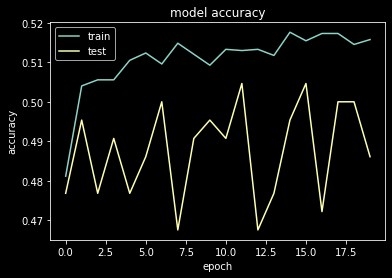

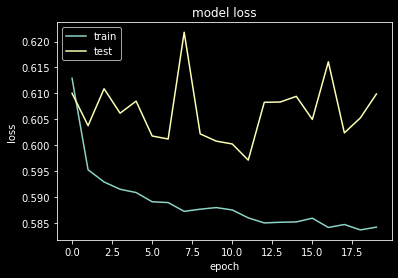

In [63]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [64]:
data = model.predict(X_test_s_2022)
predicted_data_random_results, test_result = get_predictions(data, data)

In [65]:
len(data)

216

In [66]:
predicted_data_random = pd.DataFrame(data, columns=['ProbAwayWin', 'ProbDraw', 'ProbHomeWin'], index=match_data_bl_wo_nan_s_2022.index)
match_data_bl_wo_nan_s_2022.loc[:, ['ProbAwayWin', 'ProbDraw', 'ProbHomeWin']] = predicted_data_random
match_data_bl_wo_nan_s_2022.loc[:, 'predictedResults'] = predicted_data_random_results
match_data_bl_wo_nan_s_2022.to_csv("./match_data_bl_random_22.csv")
X_test_df

C:\Users\Phili\AppData\Local\Temp/ipykernel_60464/187788532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data_bl_wo_nan_s_2022.loc[:, ['ProbAwayWin', 'ProbDraw', 'ProbHomeWin']] = predicted_data_random
C:\Users\Phili\AppData\Local\Temp/ipykernel_60464/187788532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data_bl_wo_nan_s_2022.loc[:, 'predictedResults'] = predicted_data_random_results


,Unnamed: 0.2,index,Unnamed: 0.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,QuotAttack,QuotDefend,DirectComparisonHG,DirectComparisonAG,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot
2585,2585,2585,2585,D1,16/12/14,Hamburg,Stuttgart,0,1,0,...,0.188124,0.675146,0.8,1.8,H,False,H,False,-1.0,0.444444
141,141,141,141,D1,09/12/06,Stuttgart,Bochum,1,0,2,...,0.570522,0.014081,1.9,1.5,H,True,H,True,0.4,1.266667
284,284,284,284,D1,05/05/07,Stuttgart,Mainz,2,0,2,...,2.586944,0.028878,1.7,1.2,H,True,H,True,0.5,1.416667
3925,3925,3925,3925,D1,13/04/2019,Dortmund,Mainz,2,1,2,...,0.836991,0.797375,1.6,1.0,H,True,H,True,0.6,1.600000
2919,2919,2919,2919,D1,30/01/16,Dortmund,Ingolstadt,2,0,2,...,13.128596,0.741335,2.8,0.6,H,True,H,True,2.2,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,432,432,432,D1,30/11/07,Hansa Rostock,Hannover,0,3,0,...,0.164154,1.918132,1.3,1.4,A,True,H,False,-0.1,0.928571
4889,4889,4889,4889,D1,14/05/2022,Dortmund,Hertha,2,1,2,...,3.037718,1.152922,2.4,1.2,H,True,H,True,1.2,2.000000
2966,2966,2966,2966,D1,02/03/16,Hoffenheim,Augsburg,2,1,2,...,1.496347,1.040347,1.6,1.2,H,True,H,True,0.4,1.333333
1380,1380,1380,1380,D1,15/01/11,St Pauli,Freiburg,2,2,1,...,0.854929,1.973543,0.8,1.4,H,False,H,False,-0.6,0.571429
